## Datalake

In [17]:
import boto3
import sagemaker
from pyathena import connect
import pandas as pd


In [18]:
session = boto3.session.Session()
region = session.region_name
sagemaker_session = sagemaker.Session()
bucket = sagemaker_session.default_bucket()
s3 = boto3.Session().client(service_name="s3", region_name=region)

role = sagemaker.get_execution_role()
account_id = boto3.client("sts").get_caller_identity().get("Account")
sm = boto3.Session().client(service_name="sagemaker", region_name=region)

In [19]:
print("Default bucket: {}".format(bucket))

Default bucket: sagemaker-us-east-1-429874041769


In [20]:
# Verifying the Bucket Creation
from botocore.client import ClientError

response = None

try:
    response = s3.head_bucket(Bucket=bucket)
    print(response)
    setup_s3_bucket_passed = True
except ClientError as e:
    print("[ERROR] Cannot find bucket {} in {} due to {}.".format(bucket, response, e))

{'ResponseMetadata': {'RequestId': '51K440M1TS79R5E4', 'HostId': '97acj8vaDyQw4DARwVFGHr9vhsm3aSjZj6JxyRvKtT1N2CRI0nTtVfeRke571YmZ0e5QpUPFXiA=', 'HTTPStatusCode': 200, 'HTTPHeaders': {'x-amz-id-2': '97acj8vaDyQw4DARwVFGHr9vhsm3aSjZj6JxyRvKtT1N2CRI0nTtVfeRke571YmZ0e5QpUPFXiA=', 'x-amz-request-id': '51K440M1TS79R5E4', 'date': 'Wed, 21 May 2025 11:06:35 GMT', 'x-amz-bucket-region': 'us-east-1', 'x-amz-access-point-alias': 'false', 'content-type': 'application/xml', 'transfer-encoding': 'chunked', 'server': 'AmazonS3'}, 'RetryAttempts': 0}, 'BucketRegion': 'us-east-1', 'AccessPointAlias': False}


In [21]:
s3_private_path_maintx = "s3://{}/maintx/csv".format(bucket)
print(s3_private_path_maintx)

s3://sagemaker-us-east-1-429874041769/maintx/csv


In [22]:
!aws s3 cp "vehicle_maintenance_data.csv" $s3_private_path_maintx/

upload: ./vehicle_maintenance_data.csv to s3://sagemaker-us-east-1-429874041769/maintx/csv/vehicle_maintenance_data.csv


In [23]:
print(s3_private_path_maintx)
!aws s3 ls $s3_private_path_maintx/

s3://sagemaker-us-east-1-429874041769/maintx/csv
2025-05-21 11:06:36    5828965 vehicle_maintenance_data.csv


In [24]:
database_name = "dsomaintx"
# Set S3 staging directory -- this is a temporary directory used for Athena queries
s3_staging_dir = "s3://{0}/athena/staging".format(bucket)
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

In [25]:
statement = "CREATE DATABASE IF NOT EXISTS {}".format(database_name)
print(statement)
pd.read_sql(statement, conn)

CREATE DATABASE IF NOT EXISTS dsomaintx


/tmp/ipykernel_2625/2532319348.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


Empty DataFrame
Columns: []
Index: []

In [26]:
statement = "SHOW DATABASES"

df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_2625/3999478089.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


database_name
0       default
1     dsomaintx

In [27]:
table_name_csv = "maintx_raw_data"

statement = """CREATE EXTERNAL TABLE IF NOT EXISTS {}.{}(
    Vehicle_Model string,
    Mileage int,
    Maintenance_History string,
    Reported_Issues int,
    Vehicle_Age int,
    Fuel_Type string,
    Transmission_Type string,
    Engine_Size double,
    Odometer_Reading int,
    Last_Service_Date string,
    Warranty_Expiry_Date string,
    Owner_Type string,
    Insurance_Premium int,
    Service_History int,
    Accident_History int,
    Fuel_Efficiency double,
    Tire_Condition string,
    Brake_Condition string,
    Battery_Status string,
    Need_Maintenance int
) ROW FORMAT DELIMITED 
FIELDS TERMINATED BY ',' 
LINES TERMINATED BY '\\n' 
LOCATION '{}'
TBLPROPERTIES ('skip.header.line.count'='1')""".format(
    database_name, table_name_csv, s3_private_path_maintx
)

print(statement)

CREATE EXTERNAL TABLE IF NOT EXISTS dsomaintx.maintx_raw_data(
    Vehicle_Model string,
    Mileage int,
    Maintenance_History string,
    Reported_Issues int,
    Vehicle_Age int,
    Fuel_Type string,
    Transmission_Type string,
    Engine_Size double,
    Odometer_Reading int,
    Last_Service_Date string,
    Warranty_Expiry_Date string,
    Owner_Type string,
    Insurance_Premium int,
    Service_History int,
    Accident_History int,
    Fuel_Efficiency double,
    Tire_Condition string,
    Brake_Condition string,
    Battery_Status string,
    Need_Maintenance int
) ROW FORMAT DELIMITED 
FIELDS TERMINATED BY ',' 
LINES TERMINATED BY '\n' 
LOCATION 's3://sagemaker-us-east-1-429874041769/maintx/csv'
TBLPROPERTIES ('skip.header.line.count'='1')


In [28]:
pd.read_sql(statement, conn)

/tmp/ipykernel_2625/618921652.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  pd.read_sql(statement, conn)


Empty DataFrame
Columns: []
Index: []

In [29]:
statement = "SHOW TABLES in {}".format(database_name)

df_show = pd.read_sql(statement, conn)
df_show.head(5)

/tmp/ipykernel_2625/2201015668.py:3: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_show = pd.read_sql(statement, conn)


tab_name
0  maintx_raw_data

In [30]:
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name_csv
)

df = pd.read_sql(statement, conn)

/tmp/ipykernel_2625/2896056408.py:5: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(statement, conn)


In [31]:
df.head(100)

vehicle_model  mileage maintenance_history  reported_issues  vehicle_age  \
0          Truck    58765                Good                0            4   
1            Van    60353             Average                1            7   
2            Bus    68072                Poor                0            2   
3            Bus    60849             Average                4            5   
4            Bus    45742                Poor                5            1   
..           ...      ...                 ...              ...          ...   
95    Motorcycle    31968                Good                0            1   
96           Van    74433             Average                4           10   
97           Car    45688                Poor                5            9   
98           Car    78209             Average                0            4   
99           Van    51487                Good                5            8   

   fuel_type transmission_type  engine_size  odometer_reading  \
0   Electric         Automatic       2000.0             28524   
1   Electric         Automatic       2500.0            133630   
2   Electric         Automatic       1500.0             34022   
3     Petrol         Automatic       2500.0             81636   
4     Petrol            Manual       2000.0             97162   
..       ...               ...          ...               ...   
95    Diesel            Manual       1000.0             35299   
96  Electric         Automatic       1500.0            145679   
97  Electric            Manual        800.0              9054   
98    Diesel            Manual       2500.0             45994   
99    Diesel            Manual       2000.0             29547   

   last_service_date warranty_expiry_date owner_type  insurance_premium  \
0         11/23/2023            6/24/2025     Second              20782   
1          9/21/2023             6/4/2025     Second              23489   
2          6/27/2023            4/27/2025      First              17979   
3          8/24/2023            11/5/2025     Second               6220   
4          5/25/2023            9/14/2025      Third              16446   
..               ...                  ...        ...                ...   
95         5/22/2023            3/31/2025     Second              28709   
96          4/1/2023            1/18/2026     Second              28275   
97        10/19/2023            12/8/2024      First              10501   
98        11/24/2023            3/24/2025      First              10483   
99         8/28/2023             9/5/2024      Third              25768   

    service_history  accident_history  fuel_efficiency tire_condition  \
0                 6                 3        13.622204            New   
1                 7                 0        13.625307            New   
2                 7                 0        14.306302            New   
3                 7                 3        18.709467            New   
4                 6                 2        16.977483           Good   
..              ...               ...              ...            ...   
95                4                 2        10.894891       Worn Out   
96                1                 2        19.213680            New   
97                9                 1        18.040922           Good   
98                3                 2        14.296703            New   
99                1                 3        15.395486            New   

   brake_condition battery_status  need_maintenance  
0              New           Weak                 1  
1              New           Weak                 1  
2             Good           Weak                 1  
3         Worn Out            New                 1  
4             Good           Weak                 1  
..             ...            ...               ...  
95            Good           Weak                 1  
96             New           Good                 1  
97       

## EDA

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore

In [33]:
df.describe()

mileage  reported_issues   vehicle_age   engine_size  \
count  50000.000000     50000.000000  50000.000000  50000.000000   
mean   54931.232680         2.497420      5.492260   1556.292000   
std    14401.912925         1.708781      2.875682    627.677218   
min    30001.000000         0.000000      1.000000    800.000000   
25%    42471.500000         1.000000      3.000000   1000.000000   
50%    54810.000000         2.000000      5.000000   1500.000000   
75%    67391.500000         4.000000      8.000000   2000.000000   
max    80000.000000         5.000000     10.000000   2500.000000   

       odometer_reading  insurance_premium  service_history  accident_history  \
count      50000.000000       50000.000000     50000.000000       50000.00000   
mean       75551.187060       17465.340700         5.515560           1.50156   
std        43088.105658        7223.393401         2.874899           1.11951   
min         1001.000000        5000.000000         1.000000           0.00000   
25%        38009.000000       11189.750000         3.000000           0.00000   
50%        75598.500000       17477.500000         6.000000           2.00000   
75%       112999.500000       23692.000000         8.000000           3.00000   
max       149999.000000       30000.000000        10.000000           3.00000   

       fuel_efficiency  need_maintenance  
count     50000.000000      50000.000000  
mean         14.990323          0.809960  
std           2.885583          0.392336  
min          10.000098          0.000000  
25%          12.489037          1.000000  
50%          14.986352          1.000000  
75%          17.474676          1.000000  
max          19.999968          1.000000

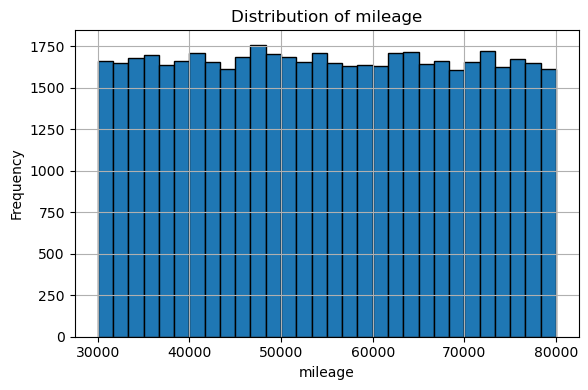

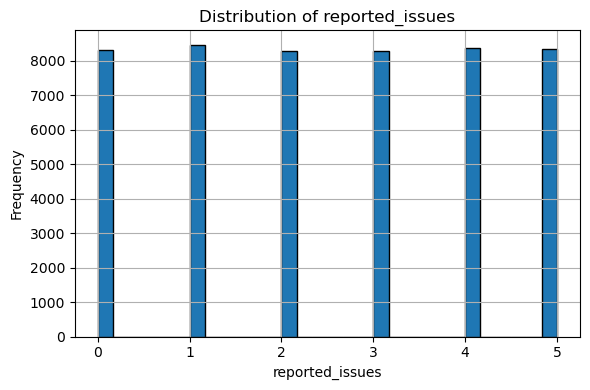

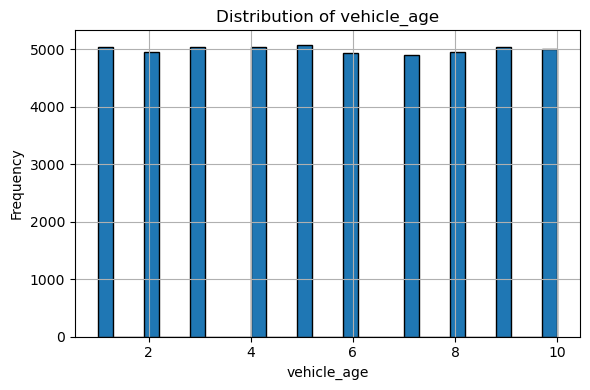

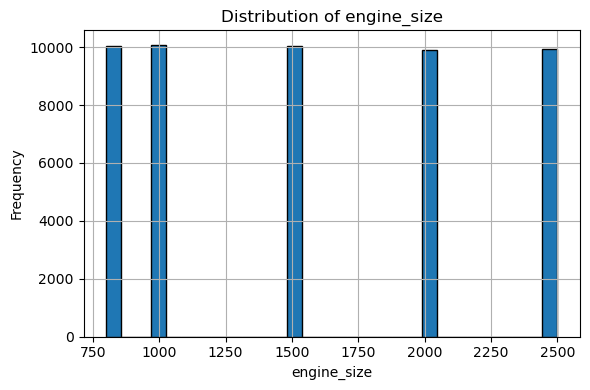

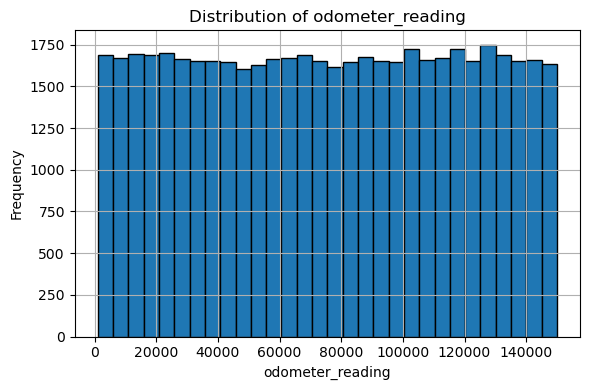

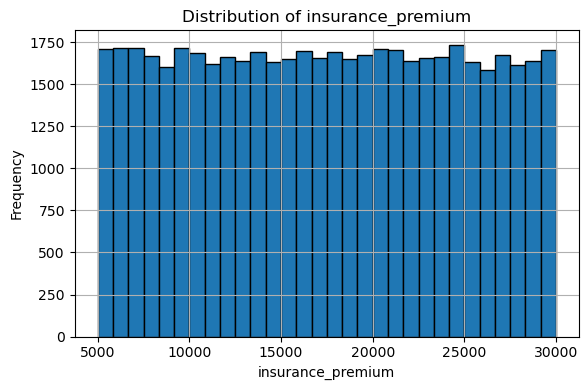

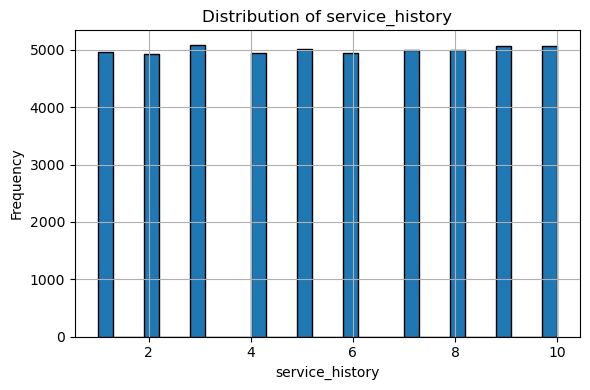

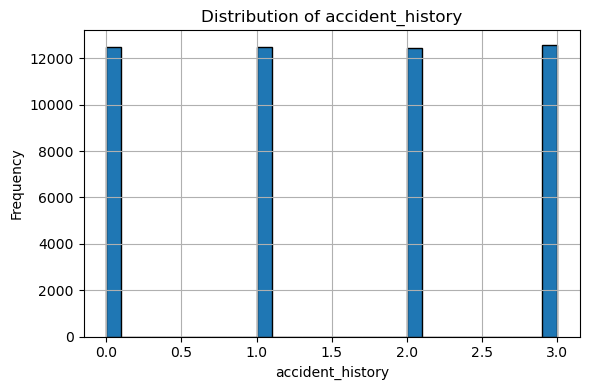

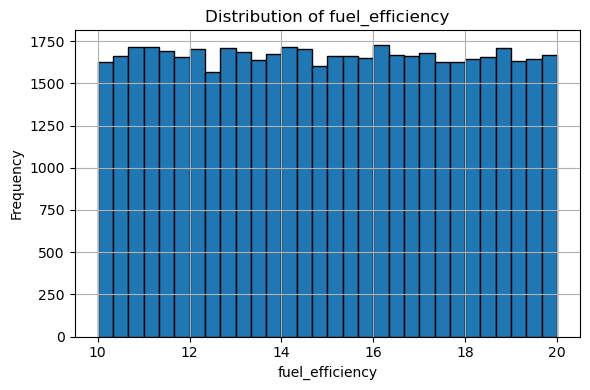

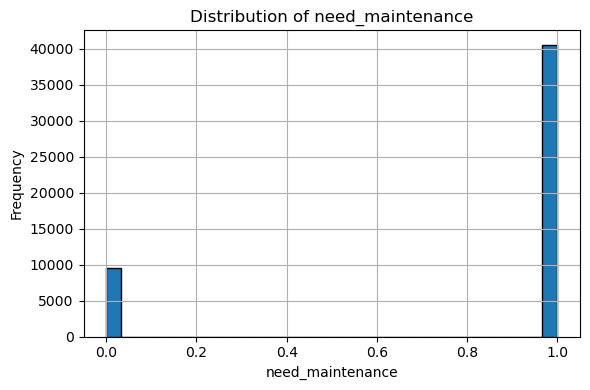

In [34]:
for i in df.columns:
    if df[i].dtype != 'object':
        plt.figure(figsize=(6, 4))
        plt.hist(df[i], bins=30, edgecolor='black')
        plt.title(f'Distribution of {i}')
        plt.xlabel(i)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [36]:
df.head()

vehicle_model  mileage maintenance_history  reported_issues  vehicle_age  \
0         Truck    58765                Good                0            4   
1           Van    60353             Average                1            7   
2           Bus    68072                Poor                0            2   
3           Bus    60849             Average                4            5   
4           Bus    45742                Poor                5            1   

  fuel_type transmission_type  engine_size  odometer_reading  \
0  Electric         Automatic       2000.0             28524   
1  Electric         Automatic       2500.0            133630   
2  Electric         Automatic       1500.0             34022   
3    Petrol         Automatic       2500.0             81636   
4    Petrol            Manual       2000.0             97162   

  last_service_date warranty_expiry_date owner_type  insurance_premium  \
0        11/23/2023            6/24/2025     Second              20782   
1         9/21/2023             6/4/2025     Second              23489   
2         6/27/2023            4/27/2025      First              17979   
3         8/24/2023            11/5/2025     Second               6220   
4         5/25/2023            9/14/2025      Third              16446   

   service_history  accident_history  fuel_efficiency tire_condition  \
0                6                 3        13.622204            New   
1                7                 0        13.625307            New   
2                7                 0        14.306302            New   
3                7                 3        18.709467            New   
4                6                 2        16.977483           Good   

  brake_condition battery_status  need_maintenance  
0             New           Weak                 1  
1             New           Weak                 1  
2            Good           Weak                 1  
3        Worn Out            New                 1  
4            Good           Weak                 1

In [37]:
df['last_service_date'] = pd.to_datetime(df['last_service_date'])
df['warranty_expiry_date'] = pd.to_datetime(df['warranty_expiry_date'])

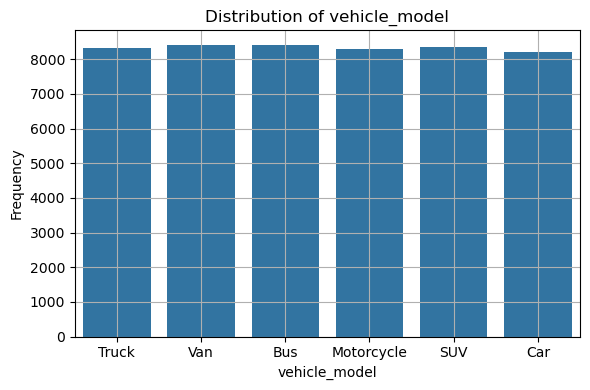

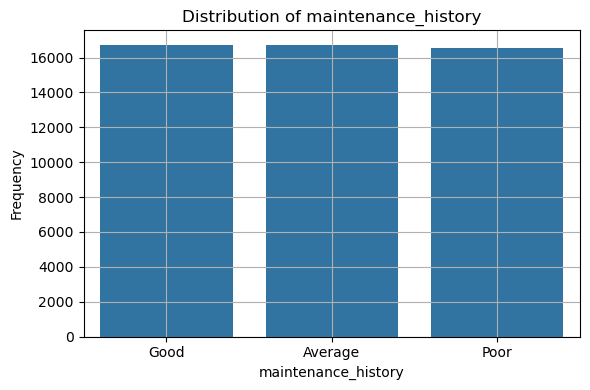

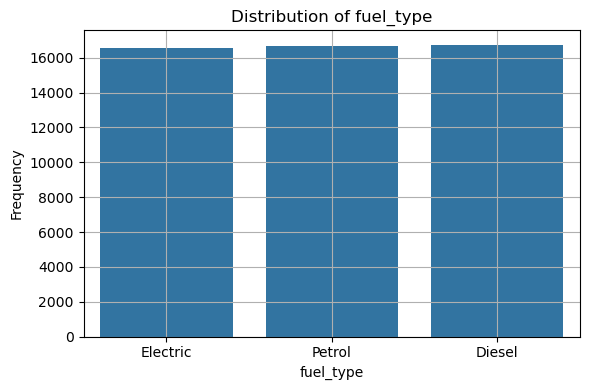

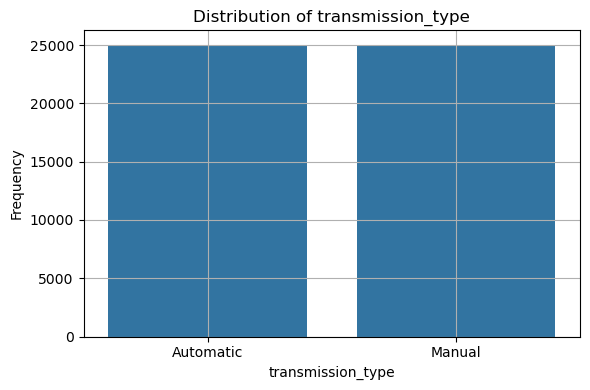

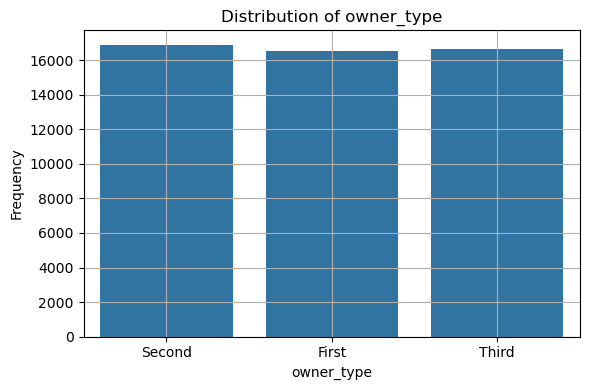

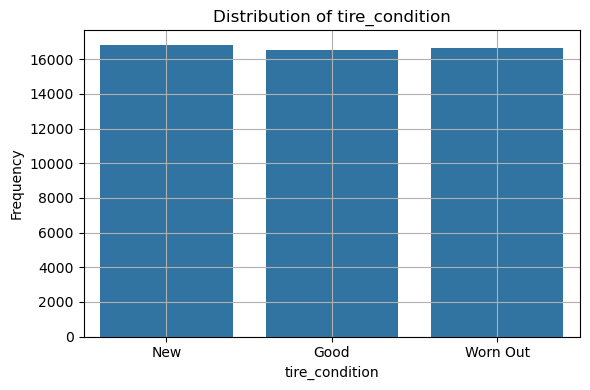

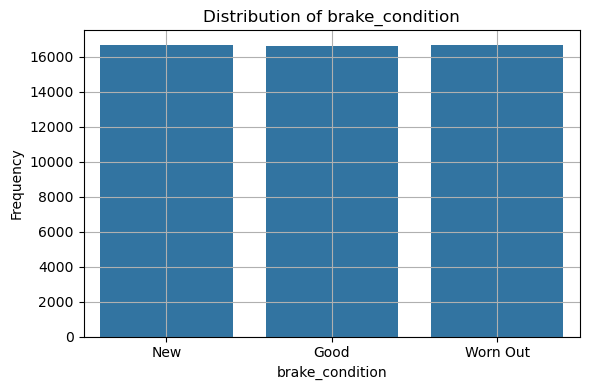

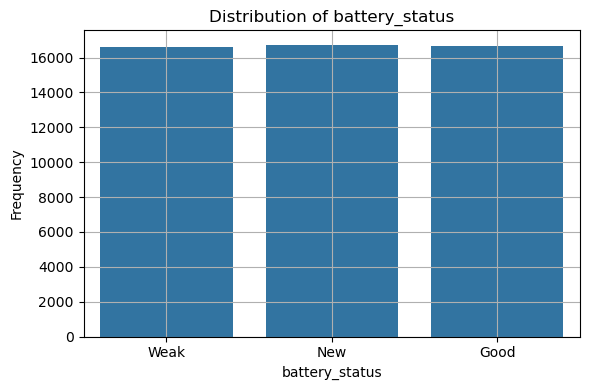

In [38]:
for i in df.columns:
    if df[i].dtype == 'object':
        plt.figure(figsize=(6, 4))
        sns.countplot(data=df, x=i)
        plt.title(f'Distribution of {i}')
        plt.xlabel(i)
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

In [39]:
df.columns

Index(['vehicle_model', 'mileage', 'maintenance_history', 'reported_issues',
       'vehicle_age', 'fuel_type', 'transmission_type', 'engine_size',
       'odometer_reading', 'last_service_date', 'warranty_expiry_date',
       'owner_type', 'insurance_premium', 'service_history',
       'accident_history', 'fuel_efficiency', 'tire_condition',
       'brake_condition', 'battery_status', 'need_maintenance'],
      dtype='object')

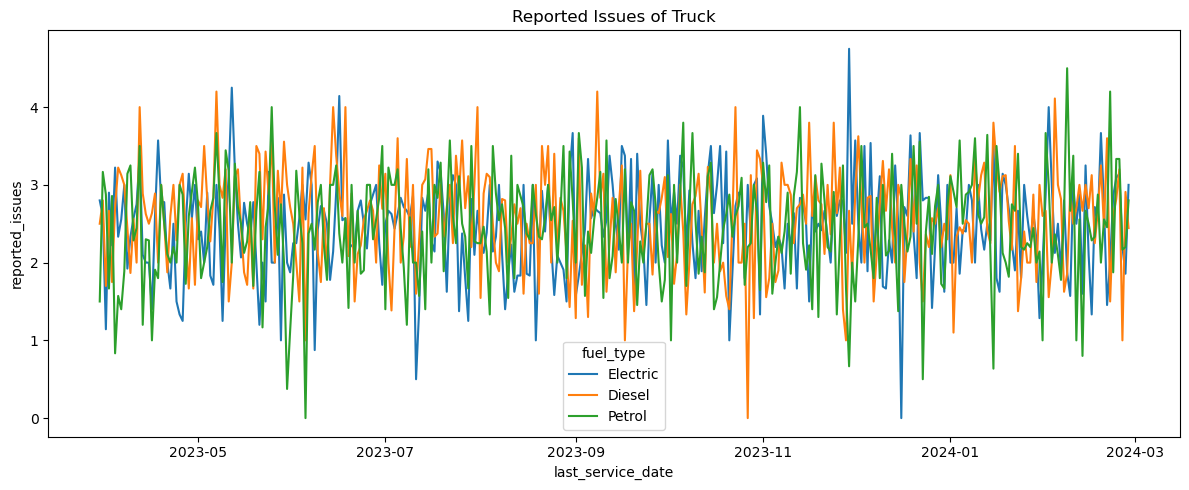

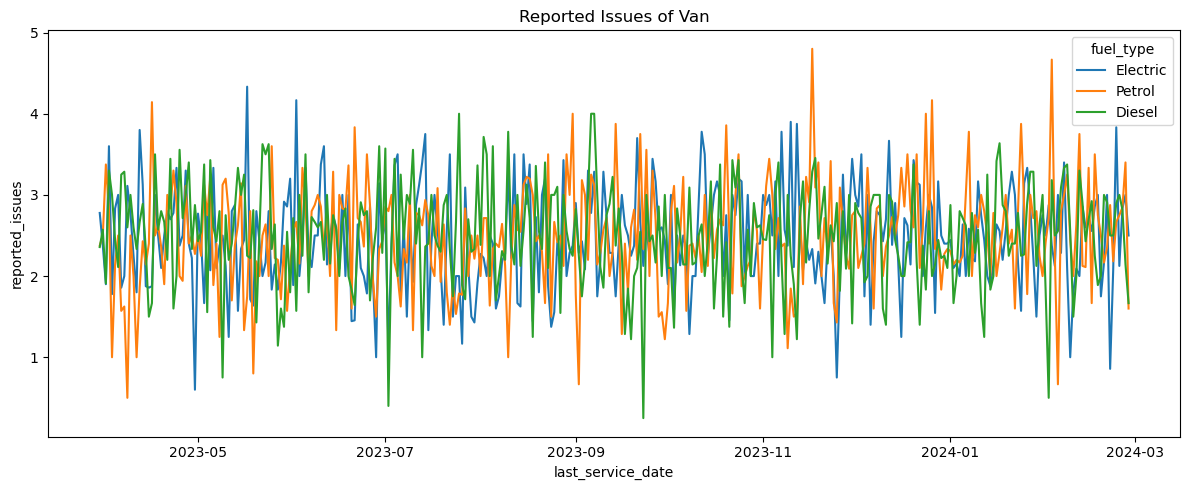

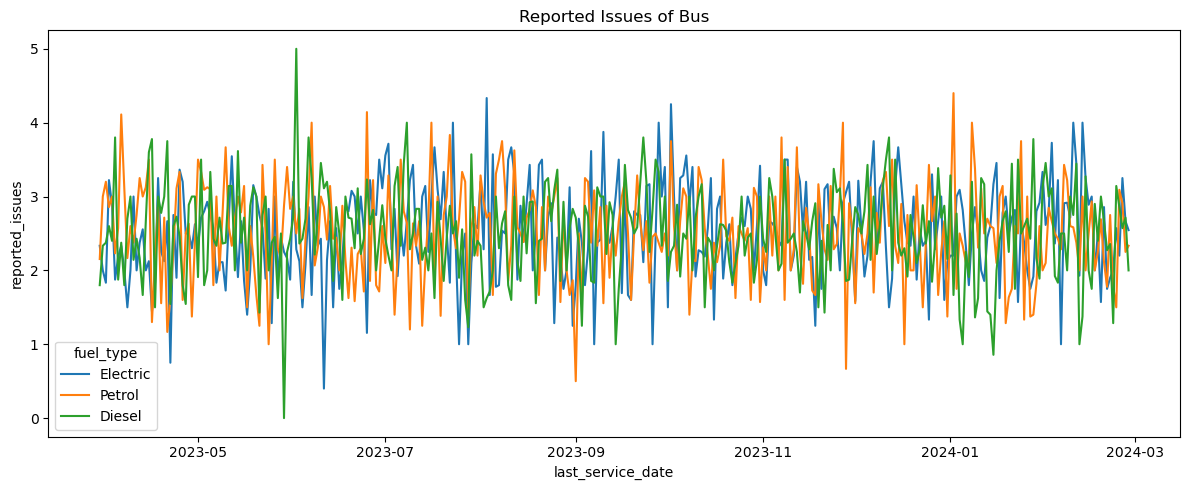

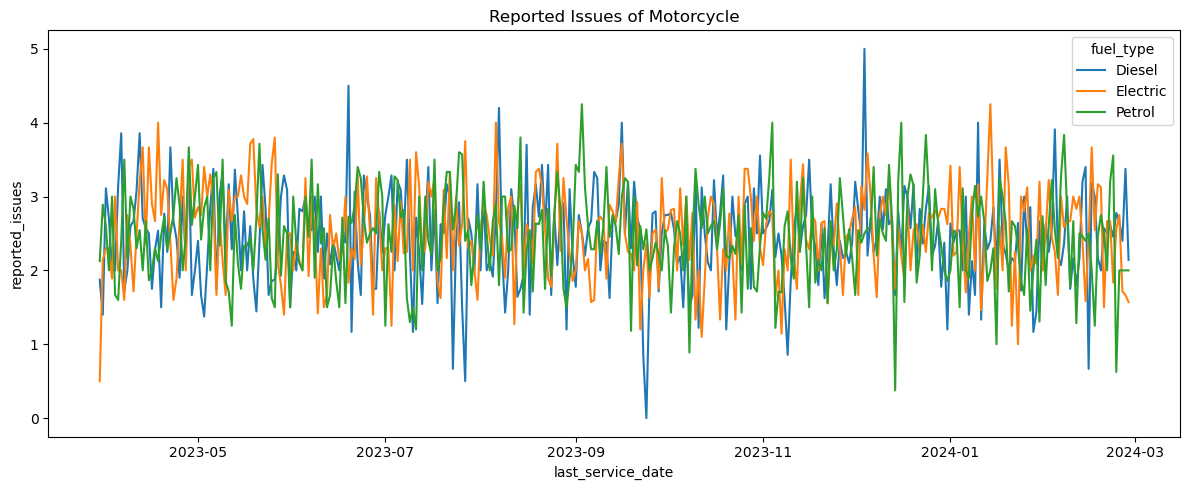

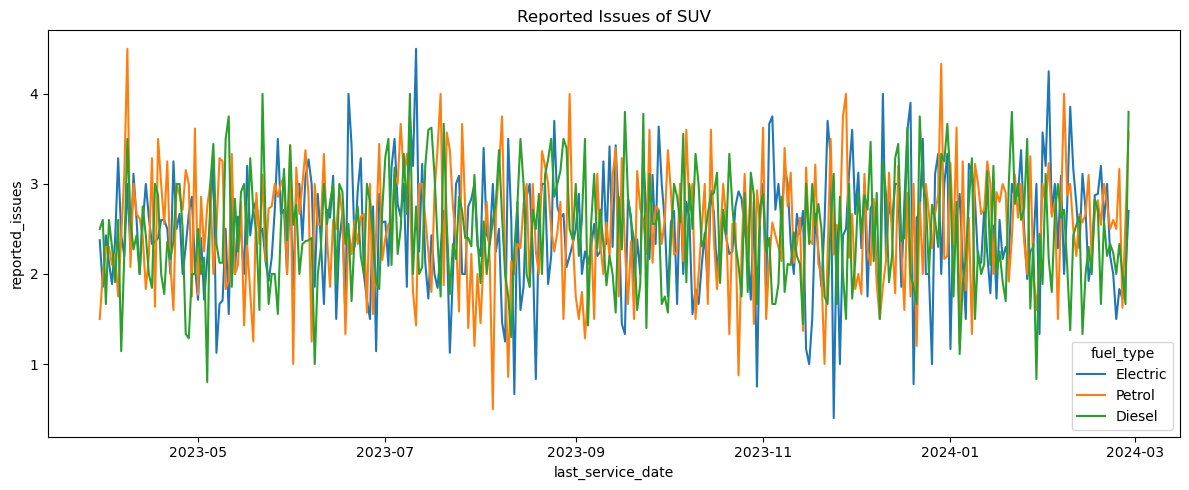

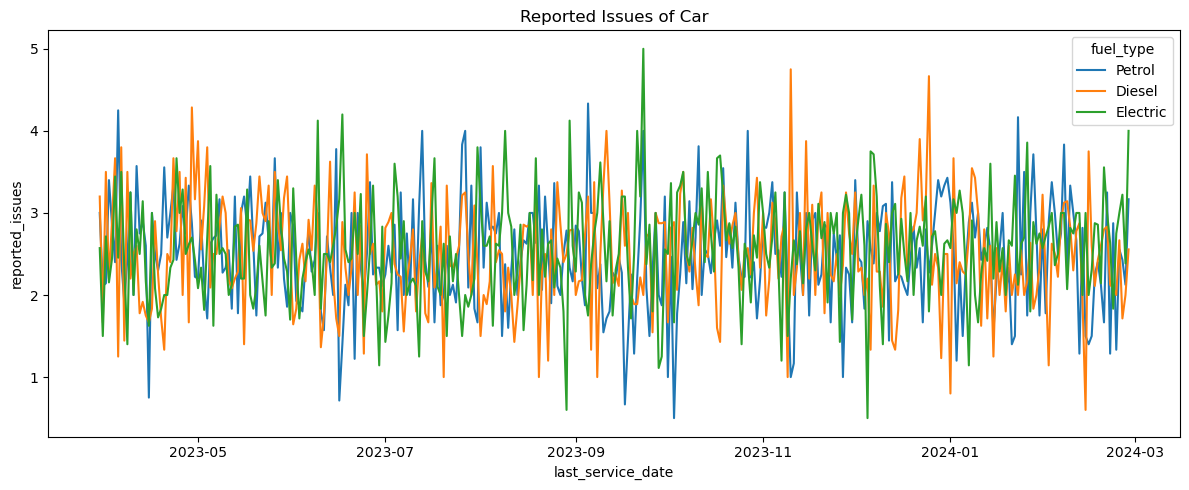

In [42]:
Vehicles = ['Truck', 'Van', 'Bus', 'Motorcycle', 'SUV', 'Car']
for i in Vehicles:
    subset = df[df['vehicle_model'] == i]
    plt.figure(figsize=(12,5))
    sns.lineplot(data = subset, x = 'last_service_date', y = 'reported_issues', hue= 'fuel_type', errorbar=None)
    plt.title(f'Reported Issues of {i}')
    plt.tight_layout()
    plt.show()

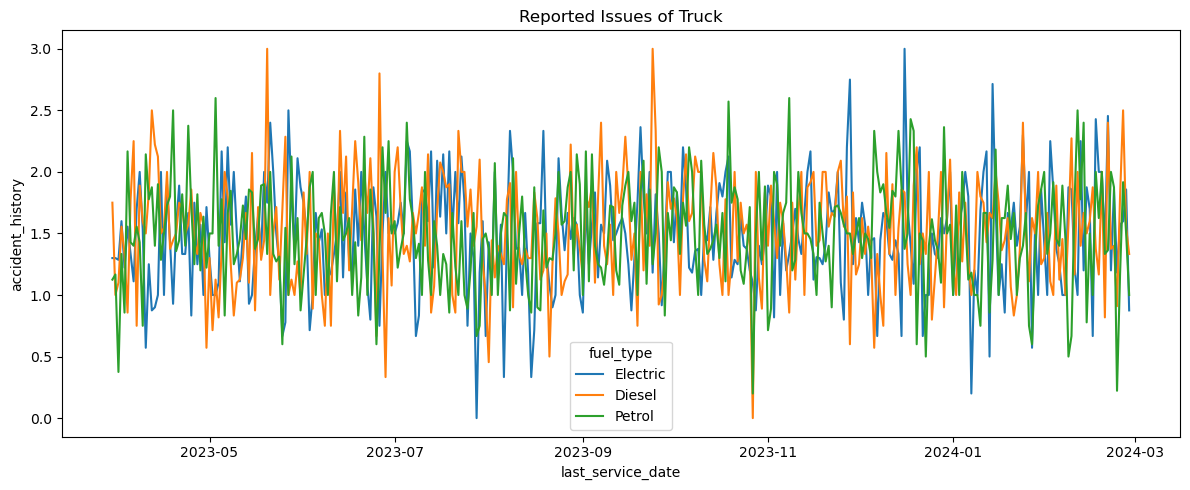

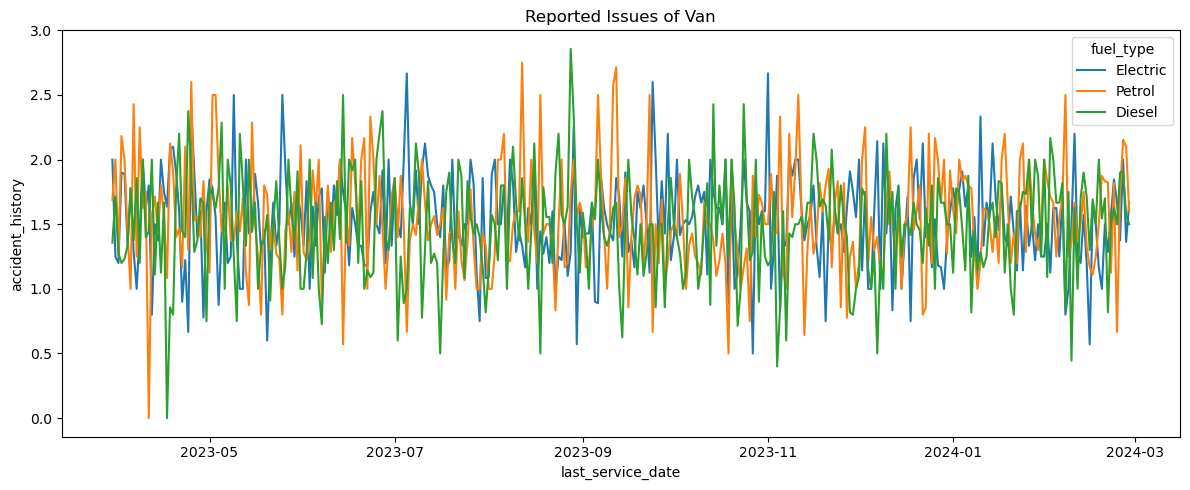

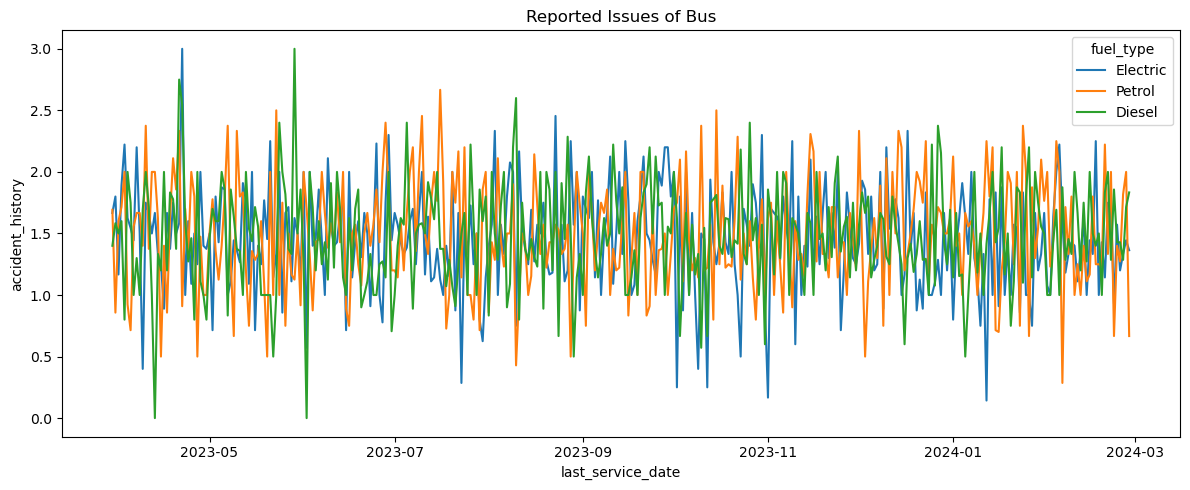

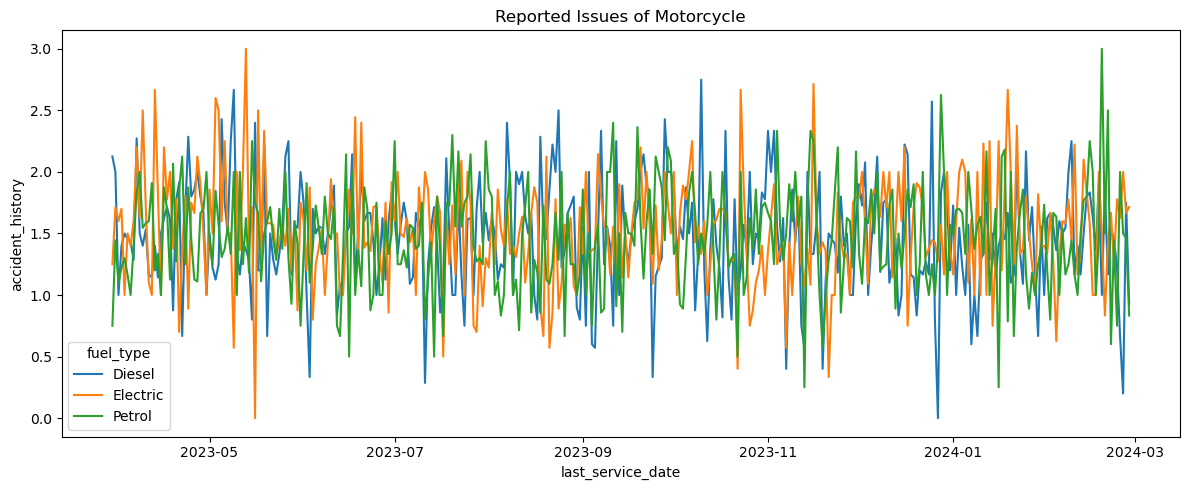

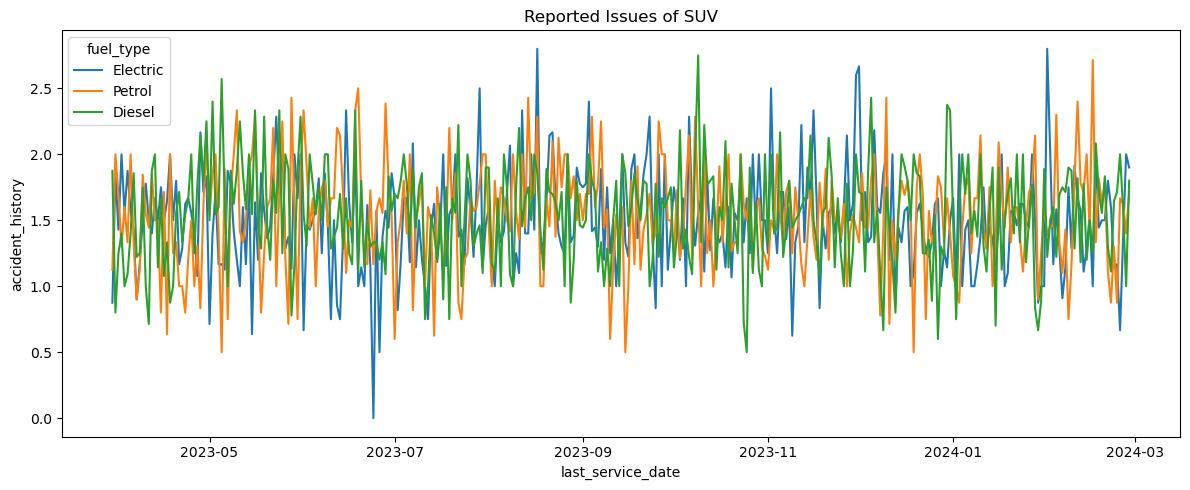

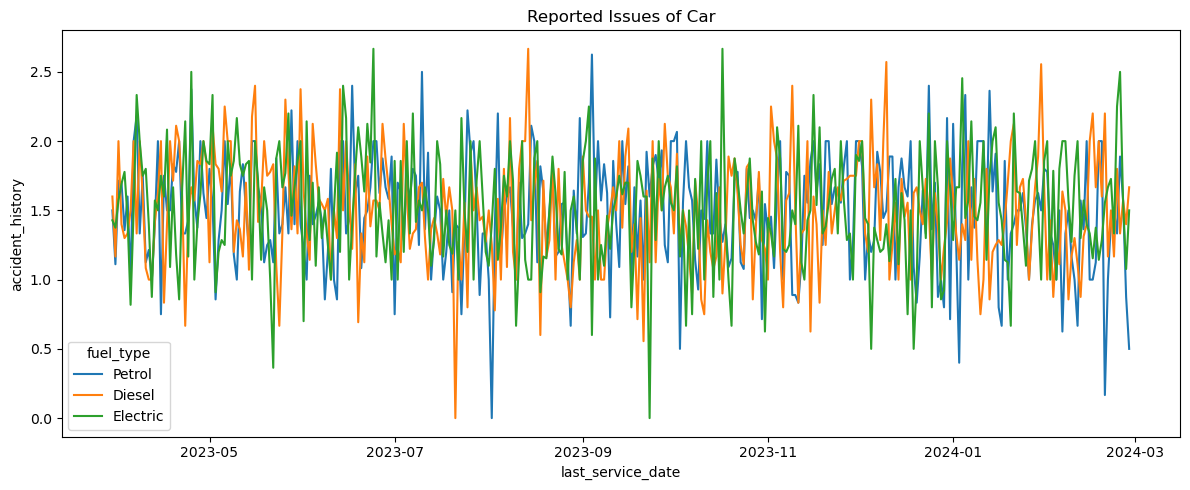

In [43]:
Vehicles = ['Truck', 'Van', 'Bus', 'Motorcycle', 'SUV', 'Car']
for i in Vehicles:
    subset = df[df['vehicle_model'] == i]
    plt.figure(figsize=(12,5))
    sns.lineplot(data = subset, x = 'last_service_date', y = 'accident_history', hue= 'fuel_type', errorbar=None)
    plt.title(f'Reported Issues of {i}')
    plt.tight_layout()
    plt.show()

In [44]:
df.columns

Index(['vehicle_model', 'mileage', 'maintenance_history', 'reported_issues',
       'vehicle_age', 'fuel_type', 'transmission_type', 'engine_size',
       'odometer_reading', 'last_service_date', 'warranty_expiry_date',
       'owner_type', 'insurance_premium', 'service_history',
       'accident_history', 'fuel_efficiency', 'tire_condition',
       'brake_condition', 'battery_status', 'need_maintenance'],
      dtype='object')

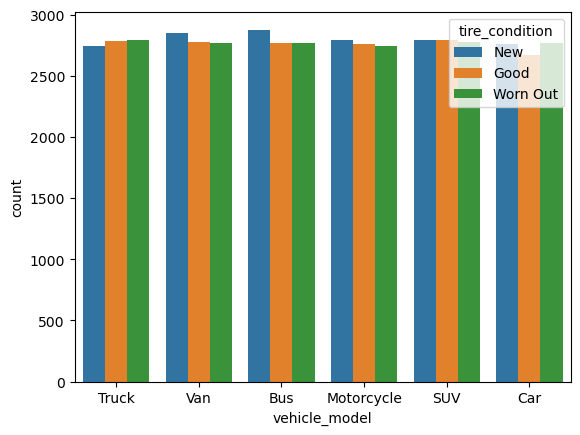

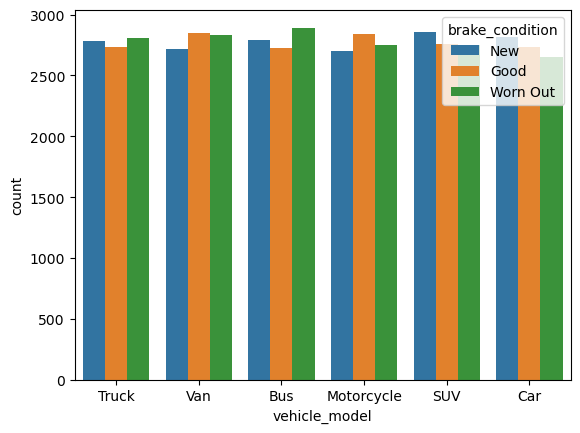

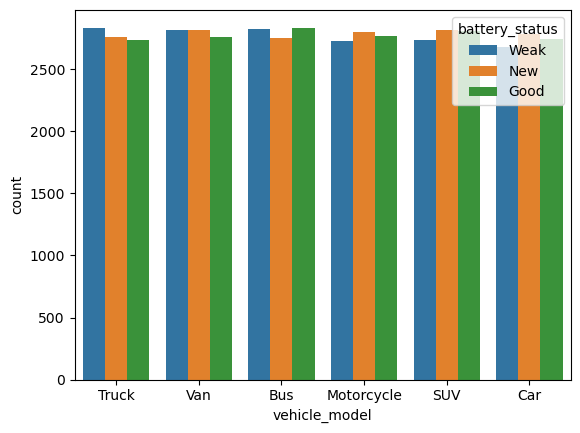

In [46]:
sns.countplot(data= df, x = 'vehicle_model', hue= 'tire_condition')
plt.show()
sns.countplot(data= df, x = 'vehicle_model', hue= 'brake_condition')
plt.show()
sns.countplot(data= df, x = 'vehicle_model', hue= 'battery_status')
plt.show()

In [47]:
df.columns

Index(['vehicle_model', 'mileage', 'maintenance_history', 'reported_issues',
       'vehicle_age', 'fuel_type', 'transmission_type', 'engine_size',
       'odometer_reading', 'last_service_date', 'warranty_expiry_date',
       'owner_type', 'insurance_premium', 'service_history',
       'accident_history', 'fuel_efficiency', 'tire_condition',
       'brake_condition', 'battery_status', 'need_maintenance'],
      dtype='object')

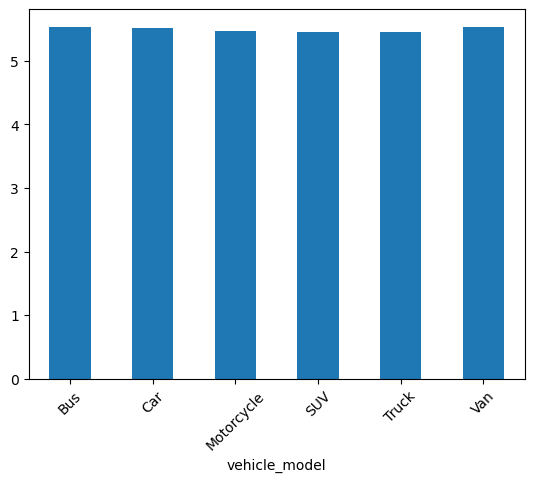

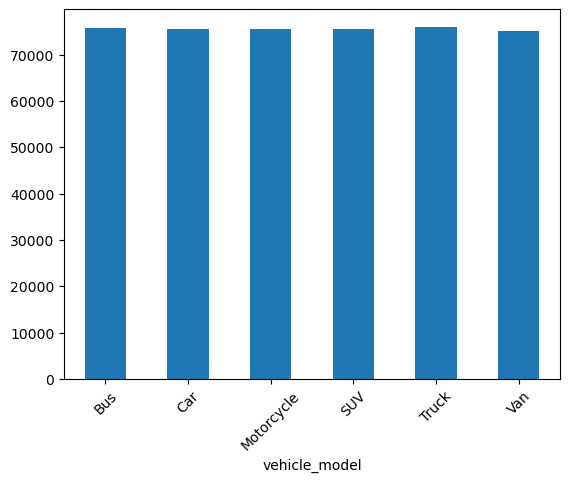

In [48]:
df.groupby('vehicle_model')['vehicle_age'].mean().plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.show()
df.groupby('vehicle_model')['odometer_reading'].mean().plot(kind = 'bar')
plt.xticks(rotation = 45)
plt.show()

In [49]:
df.head()

vehicle_model  mileage maintenance_history  reported_issues  vehicle_age  \
0         Truck    58765                Good                0            4   
1           Van    60353             Average                1            7   
2           Bus    68072                Poor                0            2   
3           Bus    60849             Average                4            5   
4           Bus    45742                Poor                5            1   

  fuel_type transmission_type  engine_size  odometer_reading  \
0  Electric         Automatic       2000.0             28524   
1  Electric         Automatic       2500.0            133630   
2  Electric         Automatic       1500.0             34022   
3    Petrol         Automatic       2500.0             81636   
4    Petrol            Manual       2000.0             97162   

  last_service_date warranty_expiry_date owner_type  insurance_premium  \
0        2023-11-23           2025-06-24     Second              20782   
1        2023-09-21           2025-06-04     Second              23489   
2        2023-06-27           2025-04-27      First              17979   
3        2023-08-24           2025-11-05     Second               6220   
4        2023-05-25           2025-09-14      Third              16446   

   service_history  accident_history  fuel_efficiency tire_condition  \
0                6                 3        13.622204            New   
1                7                 0        13.625307            New   
2                7                 0        14.306302            New   
3                7                 3        18.709467            New   
4                6                 2        16.977483           Good   

  brake_condition battery_status  need_maintenance  
0             New           Weak                 1  
1             New           Weak                 1  
2            Good           Weak                 1  
3        Worn Out            New                 1  
4            Good           Weak                 1

<Axes: xlabel='need_maintenance'>

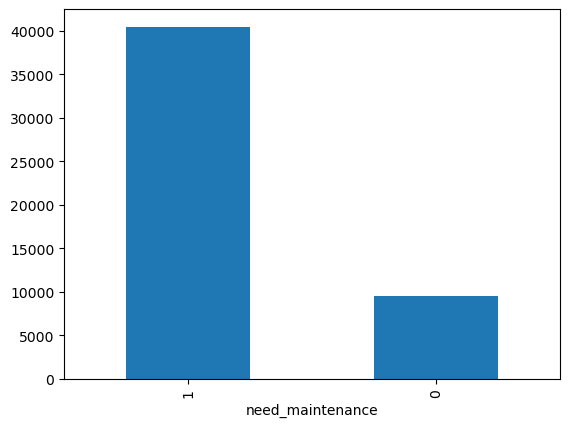

In [51]:
df['need_maintenance'].value_counts().plot(kind = 'bar')

<Axes: >

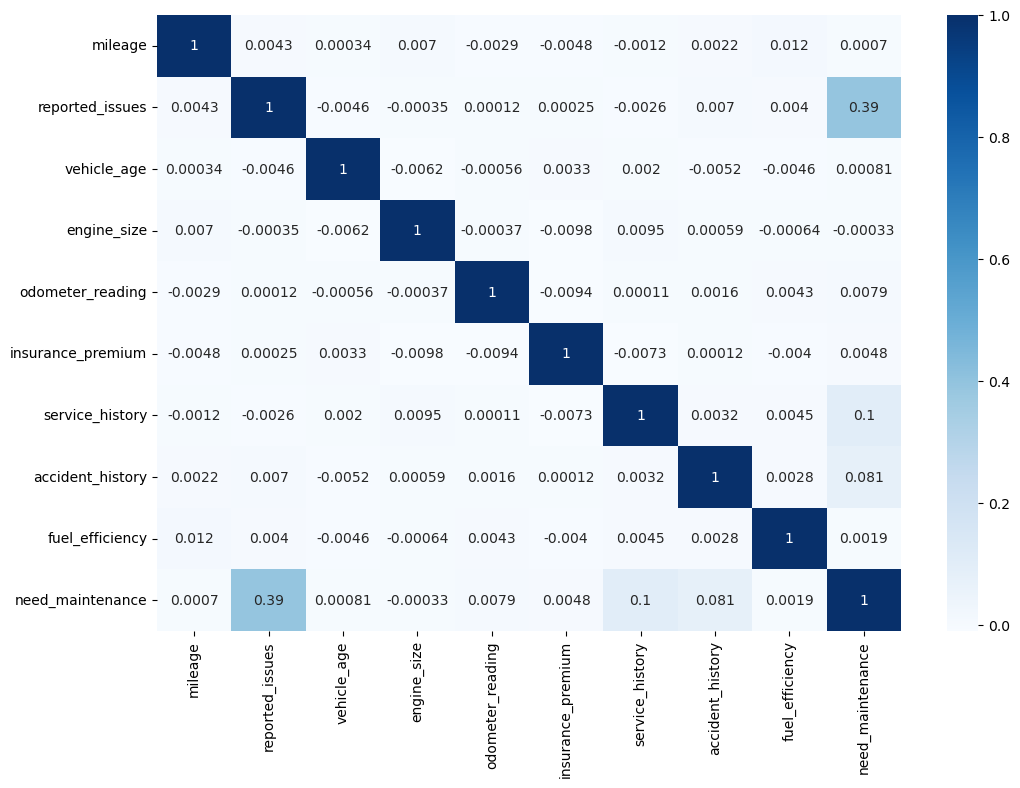

In [52]:
corr_mat = df.corr(numeric_only= True)
plt.figure(figsize=(12,8))
sns.heatmap(corr_mat, cmap="Blues", annot= True)

In [53]:
categorical_cols = ['vehicle_model', 'maintenance_history', 'fuel_type', 'transmission_type',
                    'owner_type', 'tire_condition', 'brake_condition', 'battery_status']

numeric_cols = ['mileage', 'vehicle_age', 'engine_size', 'odometer_reading',
                'insurance_premium', 'service_history', 'accident_history', 'fuel_efficiency']

In [55]:
outlier_indices = {}

for col in numeric_cols:
    z_scores = np.abs(zscore(df[col]))
    outliers = df[z_scores > 3]
    outlier_indices[col] = outliers.index.tolist()
    print(f"{col} has {len(outliers)} outliers")

mileage has 0 outliers
vehicle_age has 0 outliers
engine_size has 0 outliers
odometer_reading has 0 outliers
insurance_premium has 0 outliers
service_history has 0 outliers
accident_history has 0 outliers
fuel_efficiency has 0 outliers


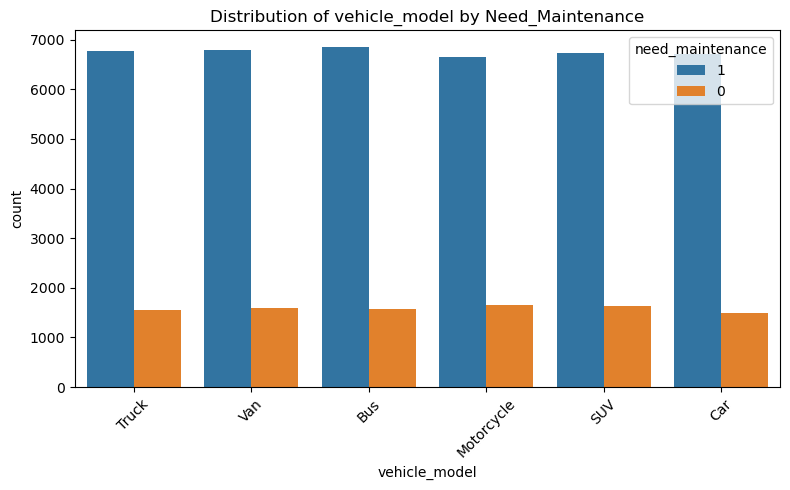

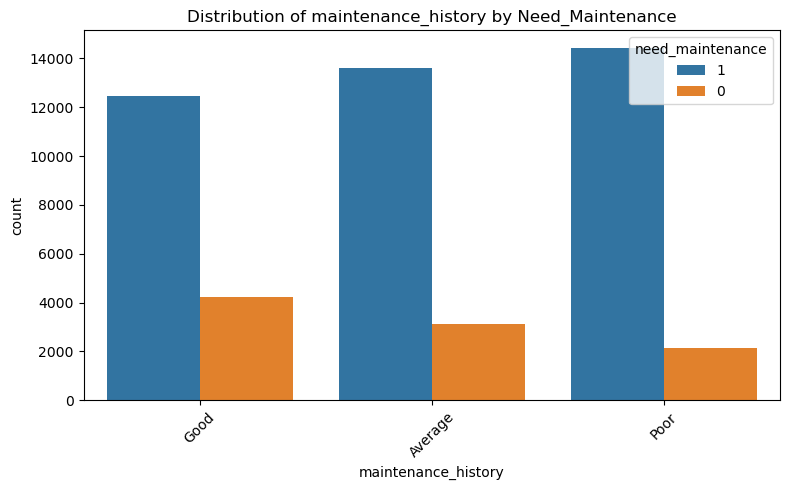

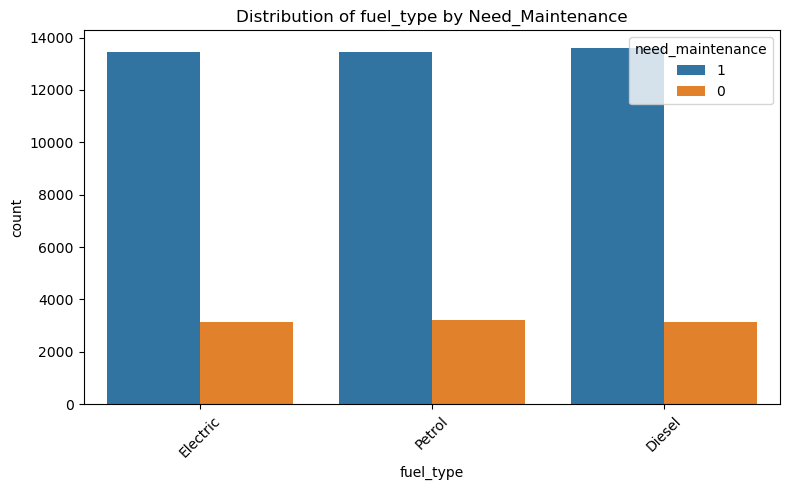

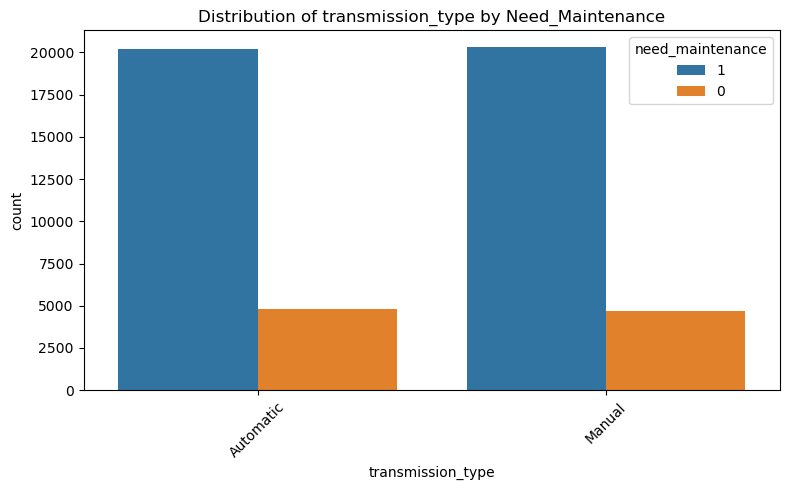

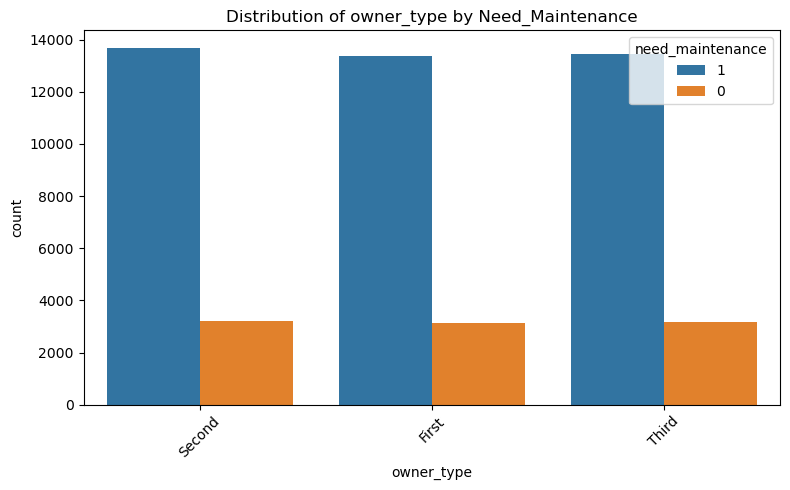

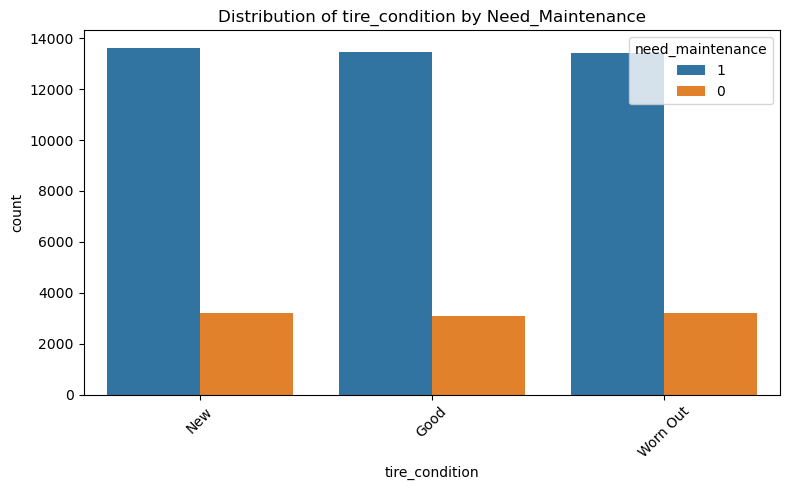

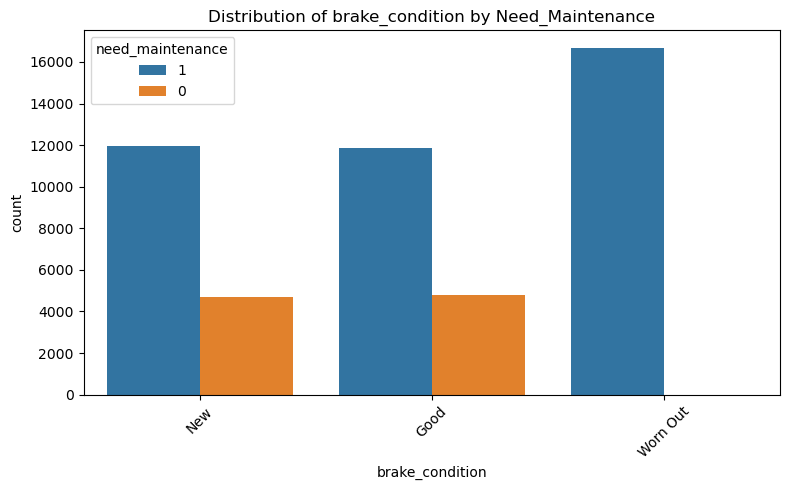

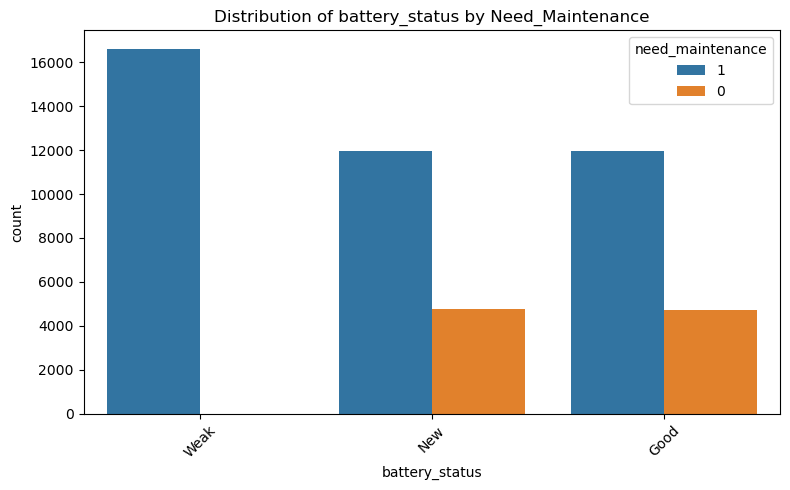

In [57]:
df['need_maintenance'] = df['need_maintenance'].astype(str)

for col in categorical_cols:
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x=col, hue='need_maintenance')
    plt.title(f'Distribution of {col} by Need_Maintenance')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [59]:
print("Chi-square test results (Col < 0.5 indicates significant association):")
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['need_maintenance'])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f'Chi-square test for {col}: chi2 = {chi2:.2f}, p-value = {p:.4f}')

Chi-square test results (Col < 0.5 indicates significant association):
Chi-square test for vehicle_model: chi2 = 10.64, p-value = 0.0590
Chi-square test for maintenance_history: chi2 = 835.19, p-value = 0.0000
Chi-square test for fuel_type: chi2 = 2.02, p-value = 0.3640
Chi-square test for transmission_type: chi2 = 0.80, p-value = 0.3714
Chi-square test for owner_type: chi2 = 0.13, p-value = 0.9348
Chi-square test for tire_condition: chi2 = 2.03, p-value = 0.3619
Chi-square test for brake_condition: chi2 = 5876.65, p-value = 0.0000
Chi-square test for battery_status: chi2 = 5840.46, p-value = 0.0000


## Feature Engineering

In [62]:
from sklearn.preprocessing import LabelEncoder

In [60]:
df[['service_history', 'accident_history', 'reported_issues']]

df['hist_record'] = (df['service_history'] + df['accident_history'] + df['reported_issues']) /  3

df_updated = df.copy()

df_updated.drop(columns= ['service_history', 'accident_history', 'reported_issues'], axis= 1, inplace= True)

df_updated.head()

vehicle_model  mileage maintenance_history  vehicle_age fuel_type  \
0         Truck    58765                Good            4  Electric   
1           Van    60353             Average            7  Electric   
2           Bus    68072                Poor            2  Electric   
3           Bus    60849             Average            5    Petrol   
4           Bus    45742                Poor            1    Petrol   

  transmission_type  engine_size  odometer_reading last_service_date  \
0         Automatic       2000.0             28524        2023-11-23   
1         Automatic       2500.0            133630        2023-09-21   
2         Automatic       1500.0             34022        2023-06-27   
3         Automatic       2500.0             81636        2023-08-24   
4            Manual       2000.0             97162        2023-05-25   

  warranty_expiry_date owner_type  insurance_premium  fuel_efficiency  \
0           2025-06-24     Second              20782        13.622204   
1           2025-06-04     Second              23489        13.625307   
2           2025-04-27      First              17979        14.306302   
3           2025-11-05     Second               6220        18.709467   
4           2025-09-14      Third              16446        16.977483   

  tire_condition brake_condition battery_status need_maintenance  hist_record  
0            New             New           Weak                1     3.000000  
1            New             New           Weak                1     2.666667  
2            New            Good           Weak                1     2.333333  
3            New        Worn Out            New                1     4.666667  
4           Good            Good           Weak                1     4.333333

In [61]:
object_col = []

for i in df_updated.columns:
    if df[i].dtype == 'object':
        object_col.append(i)

object_col

['vehicle_model',
 'maintenance_history',
 'fuel_type',
 'transmission_type',
 'owner_type',
 'tire_condition',
 'brake_condition',
 'battery_status',
 'need_maintenance']

In [63]:
encoder = LabelEncoder()

for encoded in object_col:
    df_updated[encoded] = encoder.fit_transform(df_updated[encoded])

df_updated


vehicle_model  mileage  maintenance_history  vehicle_age  fuel_type  \
0                  4    58765                    1            4          1   
1                  5    60353                    0            7          1   
2                  0    68072                    2            2          1   
3                  0    60849                    0            5          2   
4                  0    45742                    2            1          2   
...              ...      ...                  ...          ...        ...   
49995              1    77229                    1            6          0   
49996              4    54742                    1            4          0   
49997              5    75601                    2            4          1   
49998              1    66181                    1            7          1   
49999              1    71605                    2           10          2   

       transmission_type  engine_size  odometer_reading last_service_date  \
0                      0       2000.0             28524        2023-11-23   
1                      0       2500.0            133630        2023-09-21   
2                      0       1500.0             34022        2023-06-27   
3                      0       2500.0             81636        2023-08-24   
4                      1       2000.0             97162        2023-05-25   
...                  ...          ...               ...               ...   
49995                  0       2500.0             97404        2023-11-24   
49996                  1        800.0             13421        2023-07-14   
49997                  0       1500.0            124851        2023-09-09   
49998                  1       2500.0            103182        2023-08-26   
49999                  1       2000.0             65721        2023-07-25   

      warranty_expiry_date  owner_type  insurance_premium  fuel_efficiency  \
0               2025-06-24           1              20782        13.622204   
1               2025-06-04           1              23489        13.625307   
2               2025-04-27           0              17979        14.306302   
3               2025-11-05           1               6220        18.709467   
4               2025-09-14           2              16446        16.977483   
...                    ...         ...                ...              ...   
49995           2025-09-15           2               5217        10.357298   
49996           2025-01-21           1              15856        14.924022   
49997           2024-11-09           0               6019        19.859243   
49998           2025-05-22           2               5030        10.720555   
49999           2024-06-06           2               9171        16.328945   

       tire_condition  brake_condition  battery_status  need_maintenance  \
0                   1                1               2                 1   
1                   1                1               2                 1   
2                   1                0               2                 1   
3                   1                2               1                 1   
4                   0                0               2                 1   
...               ...              ...             ...               ...   
49995               1                0               2                 1   
49996               2                1               0                 1   
49997               2                2               2                 1   
49998               1                0               2                 1   
49999               0                1               0                 0   

       hist_record  
0         3.000000  
1         2.666667  
2         2.333333  
3         4.666667  
4         4.333333  
...            ...  
49995     2.666667  
49996     3.000000  
49997     3.333333  
49998     2.666667  
49999     3.000000  

[50000 rows x 18 columns]

In [64]:
# Calculate Mileage_Per_Year
df_updated['mileage_per_year'] = df_updated['mileage'] / df_updated['vehicle_age']

df_updated

vehicle_model  mileage  maintenance_history  vehicle_age  fuel_type  \
0                  4    58765                    1            4          1   
1                  5    60353                    0            7          1   
2                  0    68072                    2            2          1   
3                  0    60849                    0            5          2   
4                  0    45742                    2            1          2   
...              ...      ...                  ...          ...        ...   
49995              1    77229                    1            6          0   
49996              4    54742                    1            4          0   
49997              5    75601                    2            4          1   
49998              1    66181                    1            7          1   
49999              1    71605                    2           10          2   

       transmission_type  engine_size  odometer_reading last_service_date  \
0                      0       2000.0             28524        2023-11-23   
1                      0       2500.0            133630        2023-09-21   
2                      0       1500.0             34022        2023-06-27   
3                      0       2500.0             81636        2023-08-24   
4                      1       2000.0             97162        2023-05-25   
...                  ...          ...               ...               ...   
49995                  0       2500.0             97404        2023-11-24   
49996                  1        800.0             13421        2023-07-14   
49997                  0       1500.0            124851        2023-09-09   
49998                  1       2500.0            103182        2023-08-26   
49999                  1       2000.0             65721        2023-07-25   

      warranty_expiry_date  owner_type  insurance_premium  fuel_efficiency  \
0               2025-06-24           1              20782        13.622204   
1               2025-06-04           1              23489        13.625307   
2               2025-04-27           0              17979        14.306302   
3               2025-11-05           1               6220        18.709467   
4               2025-09-14           2              16446        16.977483   
...                    ...         ...                ...              ...   
49995           2025-09-15           2               5217        10.357298   
49996           2025-01-21           1              15856        14.924022   
49997           2024-11-09           0               6019        19.859243   
49998           2025-05-22           2               5030        10.720555   
49999           2024-06-06           2               9171        16.328945   

       tire_condition  brake_condition  battery_status  need_maintenance  \
0                   1                1               2                 1   
1                   1                1               2                 1   
2                   1                0               2                 1   
3                   1                2               1                 1   
4                   0                0               2                 1   
...               ...              ...             ...               ...   
49995               1                0               2                 1   
49996               2                1               0                 1   
49997               2                2               2                 1   
49998               1                0               2                 1   
49999               0                1               0                 0   

       hist_record  mileage_per_year  
0         3.000000      14691.250000  
1         2.666667       8621.857143  
2         2.333333      34036.000000  
3         4.666667      12169.800000  
4         4.333333      45742.000000  
...            ...               ...  
49995     2.666667    

In [65]:
# The only concern is Tire_condition not really showing much significance when it came to the Chi-square test
# Tire_condition can be dropped from this block if it doesn't make sense to keep it
df_updated['overall_condition'] = (
    df_updated['tire_condition'] + df_updated['brake_condition'] + df_updated['battery_status']
) / 3



df_updated.drop(columns=['tire_condition', 'brake_condition', 'battery_status'], inplace=True)

df_updated


vehicle_model  mileage  maintenance_history  vehicle_age  fuel_type  \
0                  4    58765                    1            4          1   
1                  5    60353                    0            7          1   
2                  0    68072                    2            2          1   
3                  0    60849                    0            5          2   
4                  0    45742                    2            1          2   
...              ...      ...                  ...          ...        ...   
49995              1    77229                    1            6          0   
49996              4    54742                    1            4          0   
49997              5    75601                    2            4          1   
49998              1    66181                    1            7          1   
49999              1    71605                    2           10          2   

       transmission_type  engine_size  odometer_reading last_service_date  \
0                      0       2000.0             28524        2023-11-23   
1                      0       2500.0            133630        2023-09-21   
2                      0       1500.0             34022        2023-06-27   
3                      0       2500.0             81636        2023-08-24   
4                      1       2000.0             97162        2023-05-25   
...                  ...          ...               ...               ...   
49995                  0       2500.0             97404        2023-11-24   
49996                  1        800.0             13421        2023-07-14   
49997                  0       1500.0            124851        2023-09-09   
49998                  1       2500.0            103182        2023-08-26   
49999                  1       2000.0             65721        2023-07-25   

      warranty_expiry_date  owner_type  insurance_premium  fuel_efficiency  \
0               2025-06-24           1              20782        13.622204   
1               2025-06-04           1              23489        13.625307   
2               2025-04-27           0              17979        14.306302   
3               2025-11-05           1               6220        18.709467   
4               2025-09-14           2              16446        16.977483   
...                    ...         ...                ...              ...   
49995           2025-09-15           2               5217        10.357298   
49996           2025-01-21           1              15856        14.924022   
49997           2024-11-09           0               6019        19.859243   
49998           2025-05-22           2               5030        10.720555   
49999           2024-06-06           2               9171        16.328945   

       need_maintenance  hist_record  mileage_per_year  overall_condition  
0                     1     3.000000      14691.250000           1.333333  
1                     1     2.666667       8621.857143           1.333333  
2                     1     2.333333      34036.000000           1.000000  
3                     1     4.666667      12169.800000           1.333333  
4                     1     4.333333      45742.000000           0.666667  
...                 ...          ...               ...                ...  
49995                 1     2.666667      12871.500000           1.000000  
49996                 1     3.000000      13685.500000           1.000000  
49997                 1     3.333333      18900.250000           2.000000  
49998                 1     2.666667       9454.428571           1.000000  
49999                 0     3.000000       7160.500000           0.333333  

[50000 rows x 17 columns]

In [67]:
# Normalization
numeric_features = ['mileage', 'vehicle_age', 'engine_size', 'odometer_reading',
                    'insurance_premium', 'fuel_efficiency', 'hist_record',
                    'mileage_per_year', 'overall_condition']


scaler = StandardScaler()

df_updated[numeric_features] = scaler.fit_transform(df_updated[numeric_features])

df_updated

vehicle_model   mileage  maintenance_history  vehicle_age  fuel_type  \
0                  4  0.266201                    1    -0.518929          1   
1                  5  0.376465                    0     0.524312          1   
2                  0  0.912441                    2    -1.214423          1   
3                  0  0.410906                    0    -0.171182          2   
4                  0 -0.638063                    2    -1.562170          2   
...              ...       ...                  ...          ...        ...   
49995              1  1.548266                    1     0.176565          0   
49996              4 -0.013140                    1    -0.518929          0   
49997              5  1.435224                    2    -0.518929          1   
49998              1  0.781138                    1     0.524312          1   
49999              1  1.157758                    2     1.567554          2   

       transmission_type  engine_size  odometer_reading last_service_date  \
0                      0     0.706912         -1.091430        2023-11-23   
1                      0     1.503508          1.347922        2023-09-21   
2                      0    -0.089684         -0.963830        2023-06-27   
3                      0     1.503508          0.141219        2023-08-24   
4                      1     0.706912          0.501554        2023-05-25   
...                  ...          ...               ...               ...   
49995                  0     1.503508          0.507171        2023-11-24   
49996                  1    -1.204918         -1.441948        2023-07-14   
49997                  0    -0.089684          1.144174        2023-09-09   
49998                  1     1.503508          0.641270        2023-08-26   
49999                  1     0.706912         -0.228144        2023-07-25   

      warranty_expiry_date  owner_type  insurance_premium  fuel_efficiency  \
0               2025-06-24           1           0.459160        -0.474127   
1               2025-06-04           1           0.833918        -0.473052   
2               2025-04-27           0           0.071111        -0.237050   
3               2025-11-05           1          -1.556810         1.288884   
4               2025-09-14           2          -0.141118         0.688658   
...                    ...         ...                ...              ...   
49995           2025-09-15           2          -1.695666        -1.605593   
49996           2025-01-21           1          -0.222798        -0.022977   
49997           2024-11-09           0          -1.584637         1.687343   
49998           2025-05-22           2          -1.721554        -1.479705   
49999           2024-06-06           2          -1.148272         0.463905   

       need_maintenance  hist_record  mileage_per_year  overall_condition  
0                     1    -0.145766         -0.092640           0.705920  
1                     1    -0.429059         -0.482000           0.705920  
2                     1    -0.712352          1.148351          -0.000961  
3                     1     1.270701         -0.254395           0.705920  
4                     1     0.987407          1.899306          -0.707842  
...                 ...          ...               ...                ...  
49995                 1    -0.429059         -0.209380          -0.000961  
49996                 1    -0.145766         -0.157160          -0.000961  
49997                 1     0.137528          0.177373           2.119681  
49998                 1    -0.429059         -0.428589          -0.000961  
49999                 0    -0.145766         -0.575748          -1.414723  

[50000 rows x 17 columns]